In [4]:
#!/usr/bin/env python3

import json
from artificialDay import rectangle, triangle, trapezoid, sine, Day

# Define config variables
with open("../config.json") as f:
    data = json.load(f)
    artDay_data = data["day"]           # Include all the configuration to control the artifitial light

In [5]:
day = Day()
day.set_function(artDay_data)

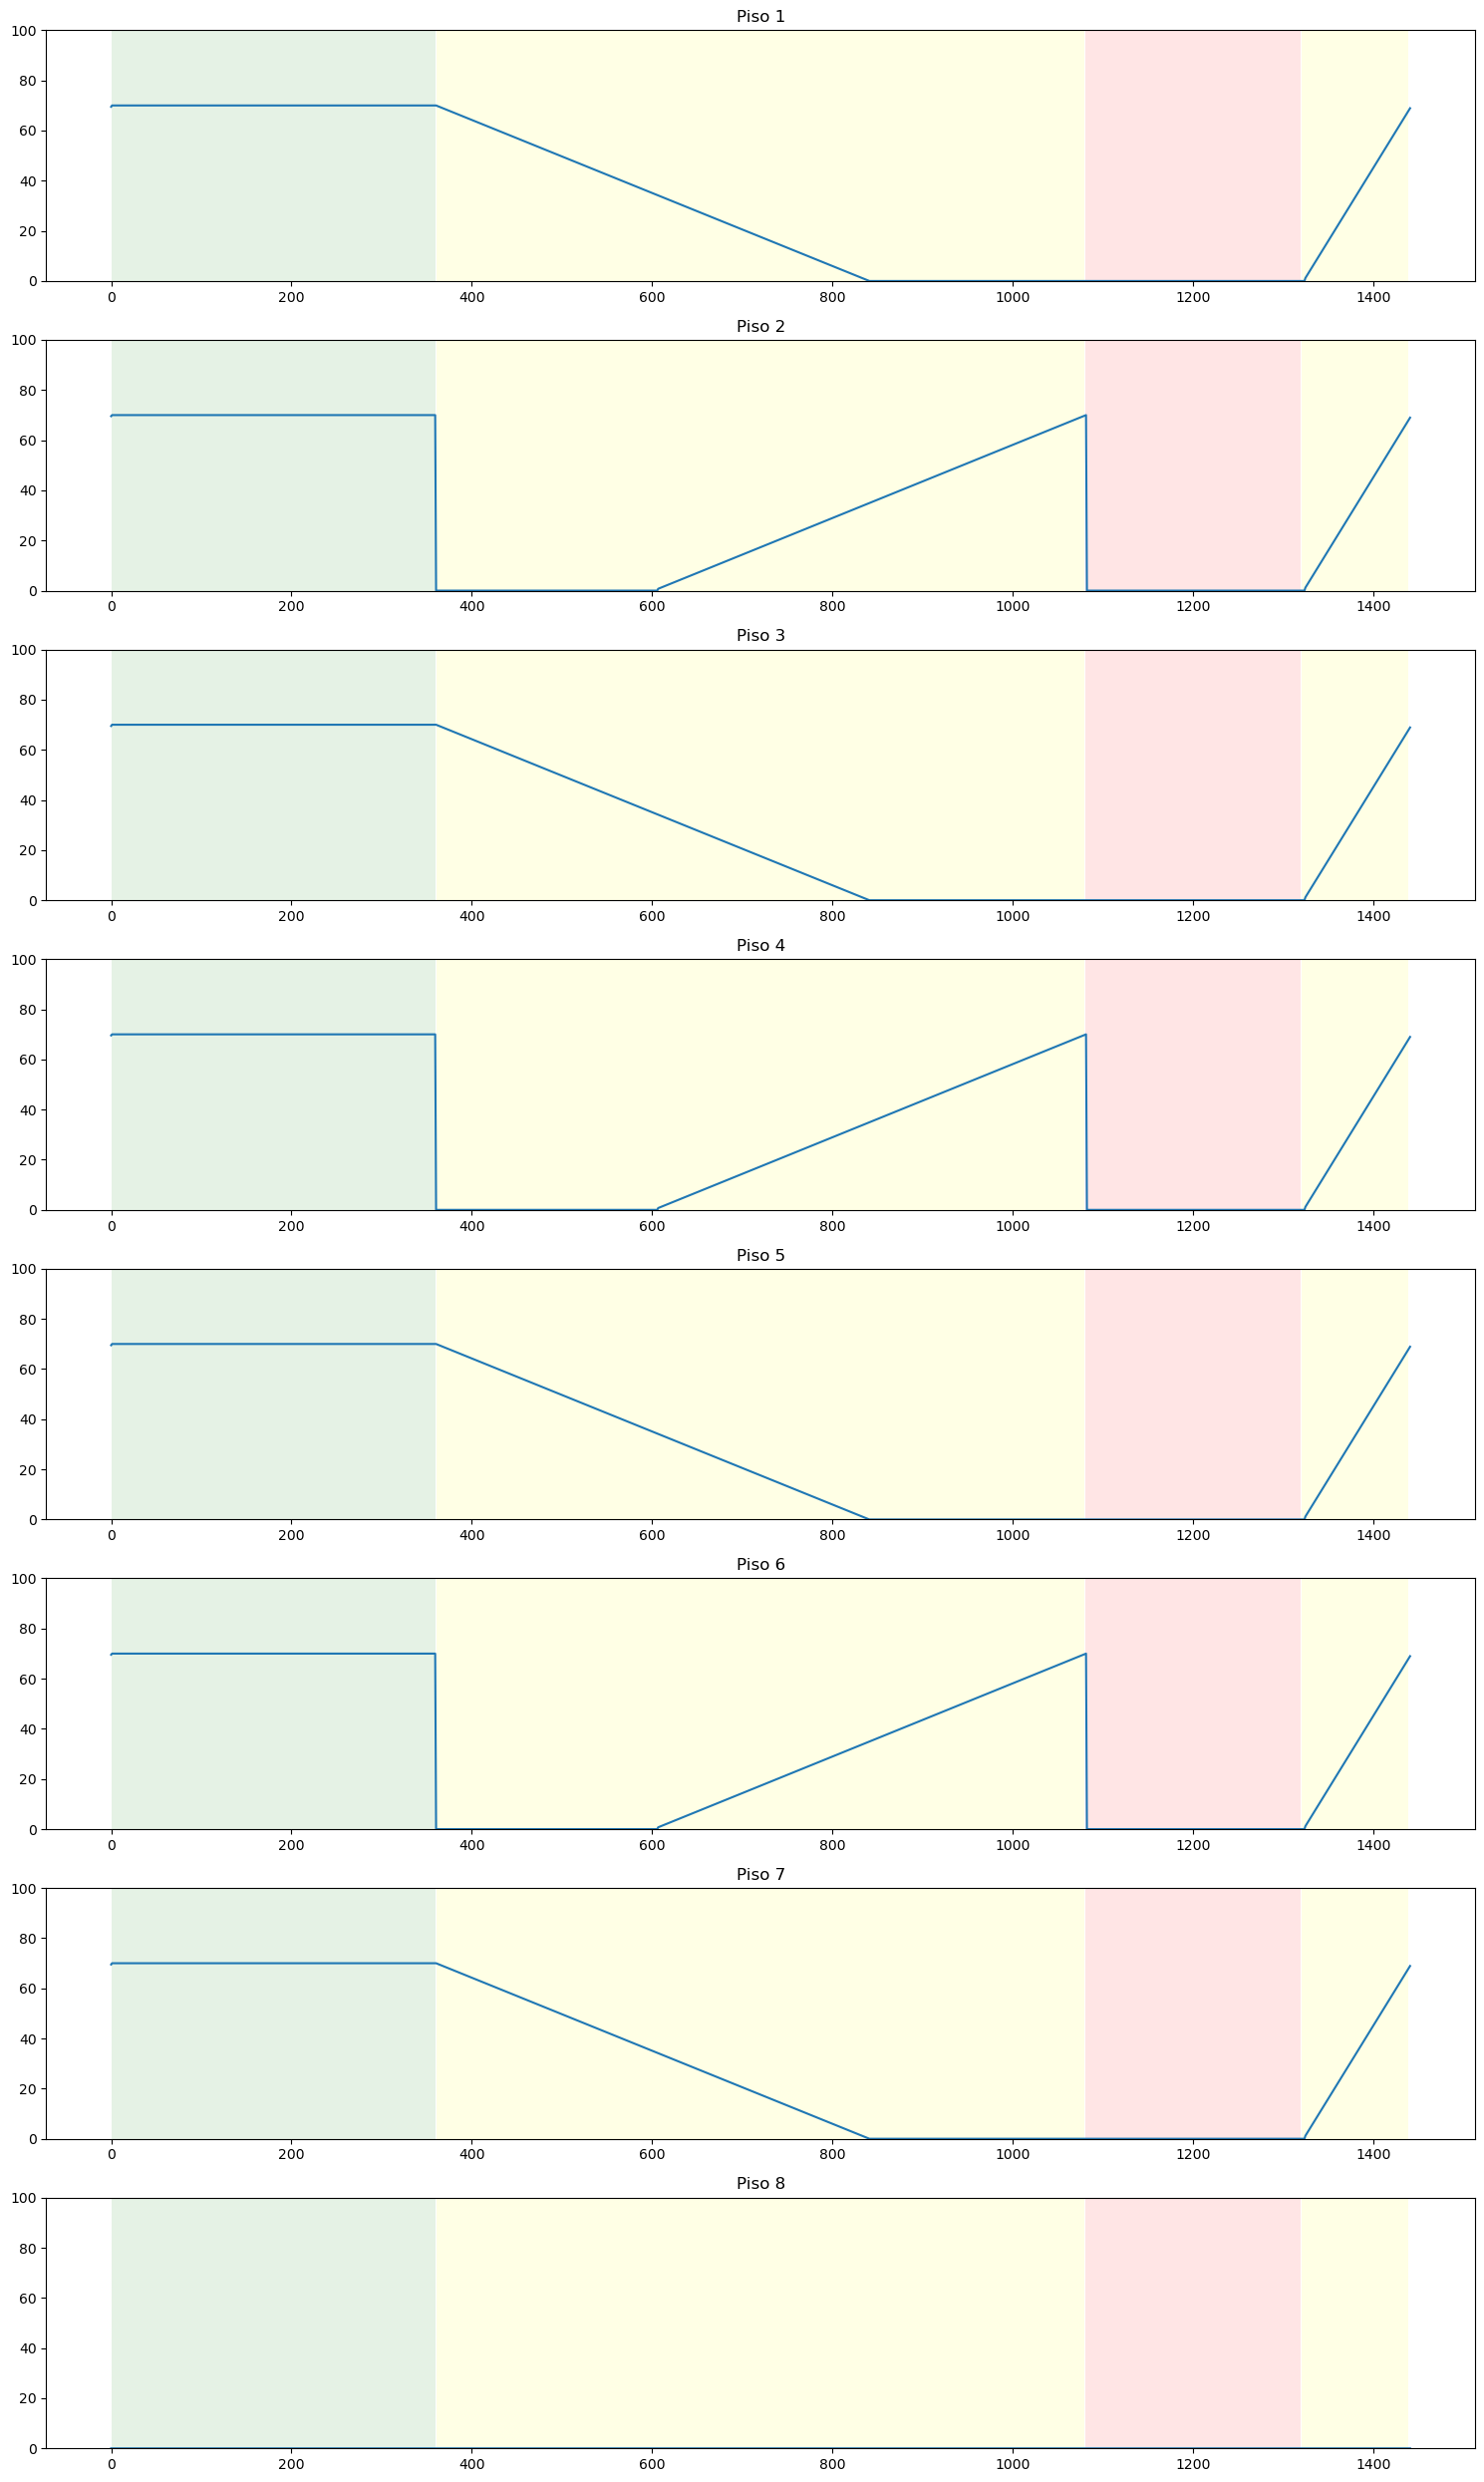

In [6]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

t = np.linspace(0, 24*60 + 1, 24*60)
y = []

for j in range(day.fl): y.append([])
for i in range(24*60):
    day.get_intensity(i)
    for j in range(day.fl): y[j].append(day.intensity[j])

fig, axs = plt.subplots(day.fl)
fig.set_figheight(25)
fig.set_figwidth(15)

for j in range(day.fl): 
    axs[j].plot(t, y[j])
    axs[j].set_ylim([0, 100])
    axs[j].title.set_text('Piso ' + str((j+1)))
    axs[j].fill_betweenx([0,100], 0, 360, facecolor='green', alpha=0.1)
    axs[j].fill_betweenx([0,100], 361, 1080, facecolor='yellow', alpha=0.1)
    axs[j].fill_betweenx([0,100], 1081,1320, facecolor='red', alpha=0.1)
    axs[j].fill_betweenx([0,100], 1321,1439, facecolor='yellow', alpha=0.1)
    
fig.tight_layout()
plt.show()